In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.utils import load_img, img_to_array, to_categorical
import cv2
from skimage.restoration import denoise_nl_means, estimate_sigma
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_inceptionv3
from keras.models import Model
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from keras.preprocessing.image import ImageDataGenerator

os.getcwd()

'c:\\Users\\zhenq\\OneDrive\\Documents\\UT_MMA\\RSM8521_AI\\Final_project'

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3
from tensorflow.keras.metrics import AUC
import math
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# 1. Parameter Definition

In [4]:
# model_list = ['ResNet50', 'VGG16', 'InceptionV3']
model_in_training = 'ResNet50'

In [5]:
seed = 22

In [24]:
# Example path
path_temp = 'c:\\Users\\zhenq\\OneDrive\\Documents\\UT_MMA\\RSM8521_AI\\Final_project\\Alzheimer_Dataset\\train\\NonDemented'

# data path
train_data_dir = 'c:\\Users\\zhenq\\OneDrive\\Documents\\UT_MMA\\RSM8521_AI\\Final_project\\Alzheimer_Dataset\\train'
test_data_dir = 'c:\\Users\\zhenq\\OneDrive\\Documents\\UT_MMA\\RSM8521_AI\\Final_project\\Alzheimer_Dataset\\test'

In [32]:
# The desired image augmentation we want to apply 
datagen = ImageDataGenerator(
    rotation_range=15,      # Randomly rotate images by up to 10 degrees
    width_shift_range=0.05,  # Randomly shift images horizontally by up to 10% of the image width
    height_shift_range=0.05, # Randomly shift images vertically by up to 10% of the image height
    shear_range=0.05,        # Randomly shear images by up to 20%
    zoom_range=0.005,         # Randomly zoom images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Do not flip images vertically
#     brightness_range= (0.8, 1.2),
    fill_mode='nearest'     # Fill any missing pixels with the nearest pixel value
)

In [7]:
# Set your training parameters
epochs = 20
batch_size = 32

# 2. Function Definition

In [8]:
# Increase Contrast
def contrast_adjustment(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    adjusted_image = clahe.apply(img_gray)
    return cv2.cvtColor(adjusted_image, cv2.COLOR_GRAY2RGB)

In [9]:
# noise reduction
def denoise_image(image, h=5):
    src = np.uint8(image)  # Convert image to 8-bit unsigned integers
    denoised_image = cv2.fastNlMeansDenoisingColored(src, None, h=h, templateWindowSize=7, searchWindowSize=21)
    return denoised_image

In [10]:
# intensity normalization
def normalize_intensity(image):
    original_shape = image.shape
    reshaped_img = image.reshape(-1,1)
    scaler = MinMaxScaler()
    normalized_image = scaler.fit_transform(reshaped_img)
    return normalized_image.reshape(original_shape)

In [11]:
# get dimensions if resize for the pre-trained model is needed
def get_size(model):
    """
    This function will instantiate the default image size used for training
    for the choice pre-trained model
        input: model choice - string
        output: img_width, img_height
    """
    if model == 'InceptionV3':
        img_width, img_height = 299, 299
    elif (model == 'ResNet50') | (model == 'VGG16'):
        img_width, img_height = 224, 224
    return img_width, img_height

In [12]:
# Choice of model: ResNet50, EfficientNetB0, InceptionV3
def load_img_data(data_dir, resize_option, resize_dim):
    """
    This function extracts image data, apply preprocess steps, and convert them into numpy array
        inputs: data_dir: data directory, train or test (string)
                resize_option: resize or keep orginal size (boolean)
                resize_width, resize_height: outputs from "get_size", only be used when resize_option is True; Otherwise, orginal size will be used
        output: numpy arrary of each image with associated label

    """
#     num_files_to_access = 200
    file_counter = 0

    images = []
    labels = []
    num_images_processed = 0
    for class_name in os.listdir(data_dir):
        class_folder = os.path.join(data_dir, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):

                '''
                The below code can help you extract only 200 images, for testing purpose
                '''
                # if file_counter >= num_files_to_access:
                #     break
                # print(filename)
                # file_counter += 1

                img_path = os.path.join(class_folder, filename)

                # Depending on the resize options specified at the beginning of the function, to choose whether or not to resize
                if resize_option == False:
                    img = load_img(img_path)
                else:
                    img = load_img(img_path, target_size=(resize_dim[0], resize_dim[1]), color_mode = 'rgb')
                img_array = img_to_array(img)

                # apply preprocessing
                denoised_image = denoise_image(img_array)
                contrast_adjusted_image = contrast_adjustment(denoised_image)
                normalized_image = normalize_intensity(contrast_adjusted_image)

                # append results to corresponding lists
                images.append(normalized_image)
                if class_name != "NonDemented":
                    labels.append('Demented')
                else:
                    labels.append(class_name)

                num_images_processed += 1
                if num_images_processed % 100 == 0:
                    print(f"Processed {num_images_processed} images")

    return np.array(images), np.array(labels)

In [13]:
# Data Augmentation
def augmentation_image(X_train, y_train, batch_size, datagen, augmentation_factor=0.5):
    '''
       This function takes Xtrain and Ytrain, which are two arrays. 
       Then, augment them based on the augmentation techniques we require above.  
    '''
    num_samples = X_train.shape[0]
    augmentation_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Generate two empty arrays to store the information
    augmented_images = np.empty((0, *X_train.shape[1:]), dtype=X_train.dtype)
    augmented_labels = np.empty((0,), dtype=y_train.dtype)
    
    num_batches = num_samples // batch_size + 1
    total_batches = math.ceil(num_batches * augmentation_factor)
#     total_batches = math.ceil(num_samples / batch_size)

    for i in range(total_batches):
        x_batch, y_batch = augmentation_generator.next()
        augmented_images = np.concatenate((augmented_images, x_batch))
        augmented_labels = np.concatenate((augmented_labels, y_batch))

    return augmented_images, augmented_labels

class PlotAUC(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.aucs = []

    def on_epoch_end(self, epoch, logs={}):
        self.aucs.append(logs.get('auc'))
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, epoch + 2), self.aucs, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('AUC Score')
        plt.title('Training AUC Score vs Epochs')
        plt.xticks(range(1, epoch + 2))
        plt.grid()
        plt.show()

In [42]:
class PlotAUC(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_aucs = []
        self.val_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_aucs.append(logs.get('auc'))
        self.val_aucs.append(logs.get('val_auc'))
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, epoch + 2), self.train_aucs, marker='o', label='Training AUC')
        plt.plot(range(1, epoch + 2), self.val_aucs, marker='o', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC Score')
        plt.title('Training and Validation AUC Score vs Epochs')
        plt.xticks(range(1, epoch + 2))
        plt.legend()
        plt.grid()
        plt.show()

### Data Preprocessing
To ensure the quality of the input data, we considered several preprocessing techniques that are specifically tailored for MRI images and have been widely used in neuroimaging research, including noise reduction, intensity normalization, and brain extraction. Each of these steps address different realistic challenges and reduce heterogeneities other than the key features from MRI images. These techniques will help ensure that the MRI data is suitable for machine learning models, improving their performance and generalization.<br>
1. **Noise reduction:**<br>
MRI images can contain noises, artifacts, or non-uniformities that could cause the model to overfit on these irrelevant/biased features.<br>

2. **Intensity normalization:**<br>
The intensity values of MRI images can vary across different scanners, subjects, or sessions. Therefore, normalization is essential for ensuring that the features extracted by the model are consistent across the dataset.<br>

## Preprocessing Examples

### Increase Contrast

In [22]:
# Read the input image in grayscale
img = cv2.imread(train_data_dir + '/nonDem12.jpg', 0)

# Check if the image was read correctly
if img is None:
    print("Error: Image not found or could not be read.")
else:
    print('ok')

Error: Image not found or could not be read.


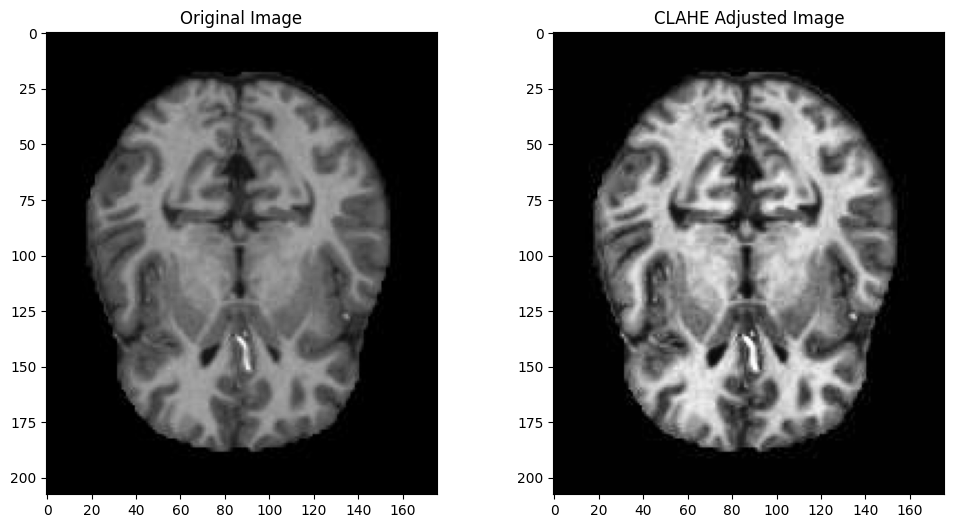

In [25]:
# Read the input image in grayscale
img = cv2.imread(path_temp + '/nonDem12.jpg', 0)

# Create a CLAHE object with specified parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to the input image
clahe_img = clahe.apply(img)

# Display the original and adjusted images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(clahe_img, cmap='gray')
plt.title('CLAHE Adjusted Image')

plt.show()

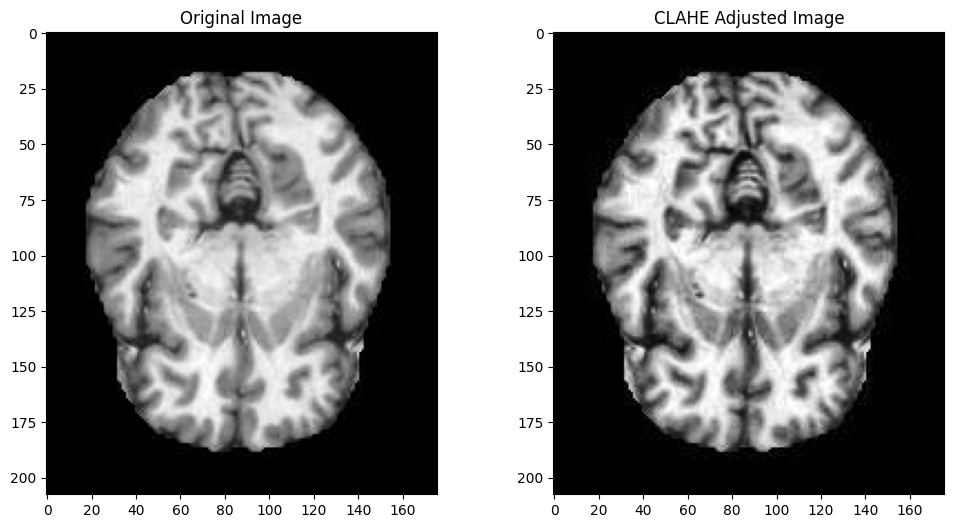

In [26]:
# Read the input image in grayscale
img = cv2.imread(path_temp + '/nonDem11.jpg', 0)

# Create a CLAHE object with specified parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to the input image
clahe_img = clahe.apply(img)

# Display the original and adjusted images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(clahe_img, cmap='gray')
plt.title('CLAHE Adjusted Image')

plt.show()

### Denoising

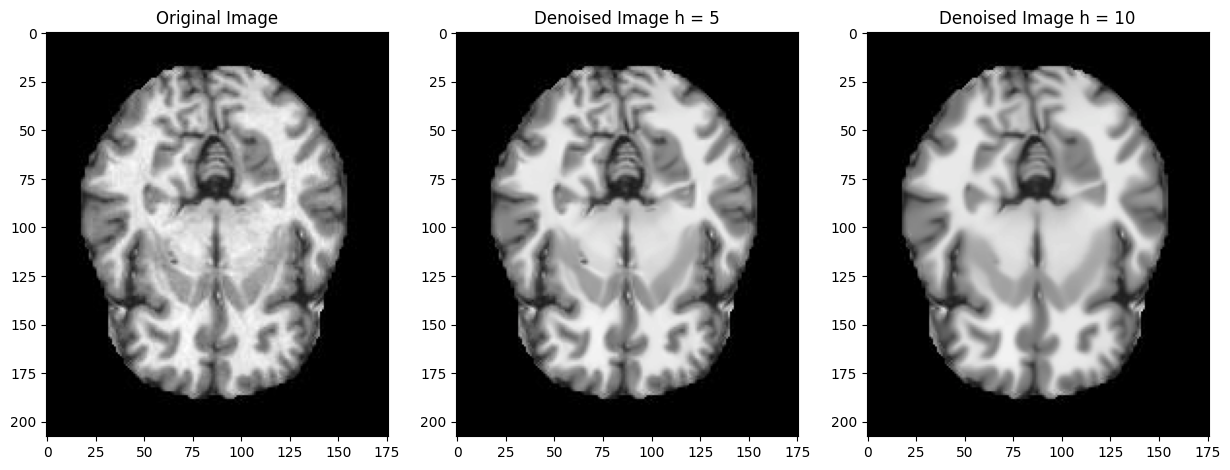

In [27]:
# Read the input image in grayscale
img = cv2.imread(path_temp + '/nonDem11.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Denoise the image
denoised_img_5 = denoise_image(img, h=5)
denoised_img_10 = denoise_image(img, h=10)

# Display the original and denoised images
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(denoised_img_5)
plt.title('Denoised Image h = 5')

plt.subplot(133)
plt.imshow(denoised_img_10)
plt.title('Denoised Image h = 10')

plt.show()

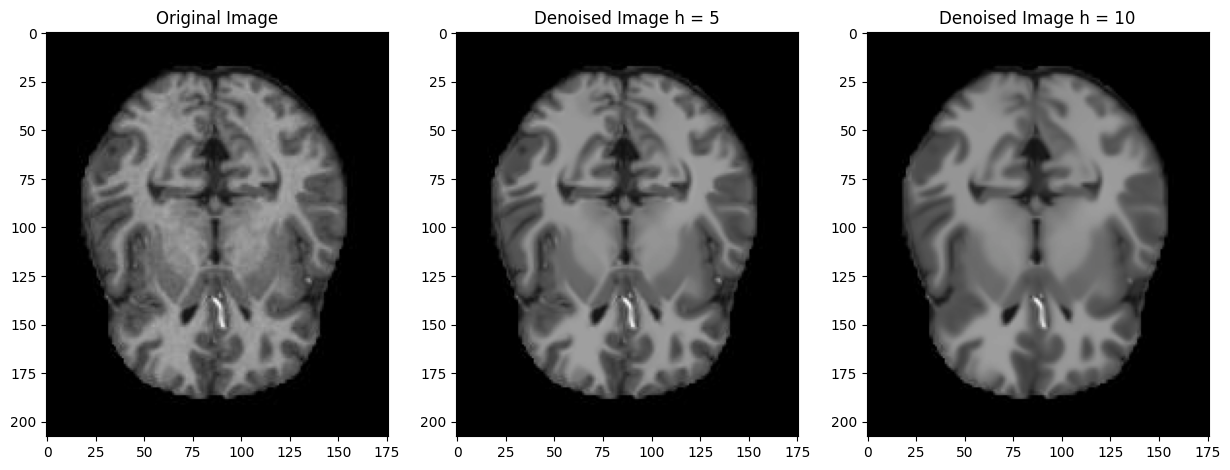

In [28]:
# Read the input image in grayscale
img = cv2.imread(path_temp + '/nonDem12.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Denoise the image
denoised_img_5 = denoise_image(img, h=5)
denoised_img_10 = denoise_image(img, h=10)

# Display the original and denoised images
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(denoised_img_5)
plt.title('Denoised Image h = 5')

plt.subplot(133)
plt.imshow(denoised_img_10)
plt.title('Denoised Image h = 10')

plt.show()

### Normalizing Intensity

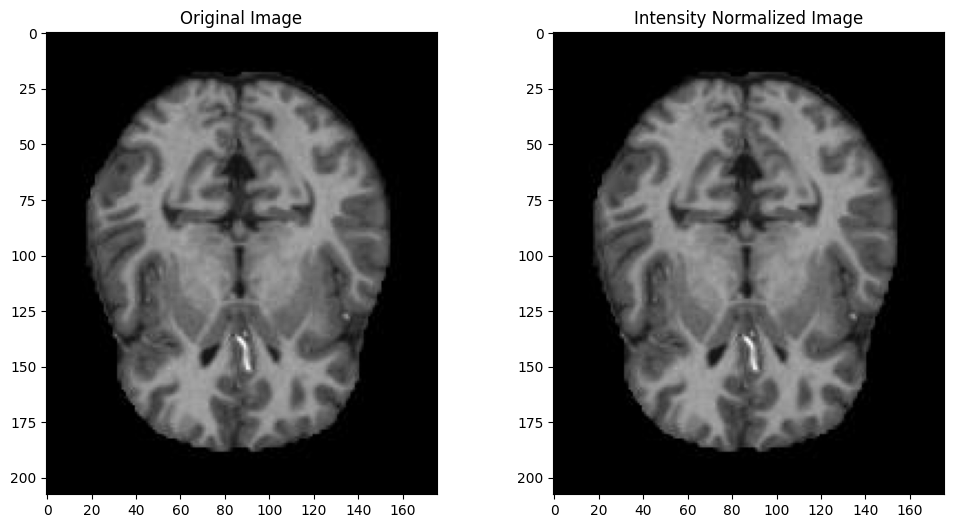

In [29]:
# Load the image in grayscale mode
img = cv2.imread(path_temp + '/nonDem12.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize the intensity of the image
normalized_img = normalize_intensity(img)

# Display the original and normalized images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(normalized_img, cmap='gray')
plt.title('Intensity Normalized Image')

plt.show()

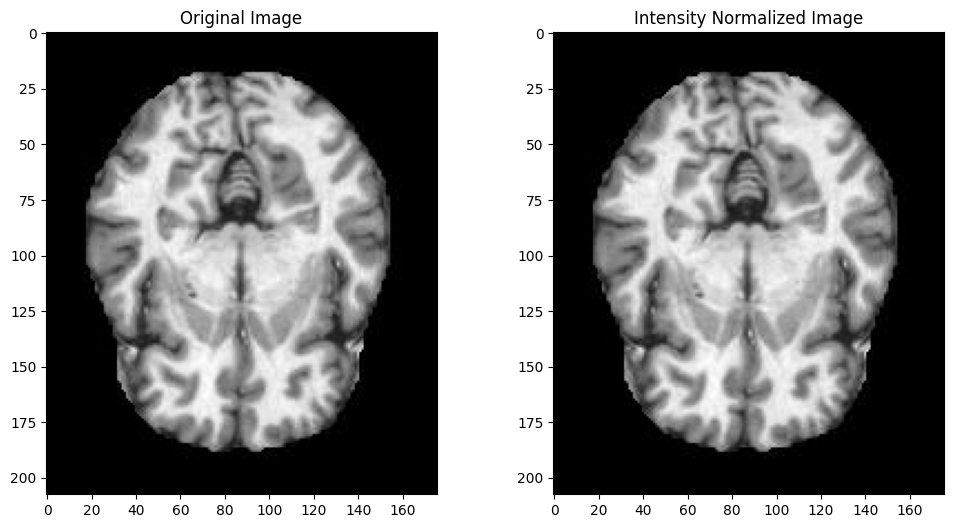

In [30]:
# Load the image in grayscale mode
img = cv2.imread(path_temp + '/nonDem11.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize the intensity of the image
normalized_img = normalize_intensity(img)

# Display the original and normalized images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(normalized_img, cmap='gray')
plt.title('Intensity Normalized Image')

plt.show()

### Example of Augmented Image

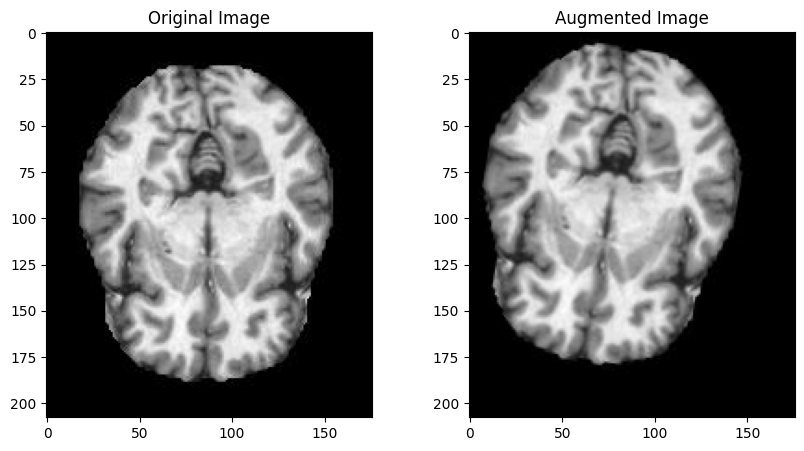

In [33]:
def single_image_augmentation(img, datagen):
    img = np.expand_dims(img, axis=0)  # Add a batch dimension to the image

    augmentation_generator = datagen.flow(img, batch_size=1)

    # Get a single augmented image
    augmented_image = augmentation_generator.next()[0]

    return augmented_image

# Load an image
img = cv2.imread(path_temp + '/nonDem11.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply augmentation to the image
augmented_img = single_image_augmentation(img, datagen)

# Display original and augmented images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[1].imshow(augmented_img.astype('uint8'))
axes[1].set_title('Augmented Image')

plt.show()

# 3. Model Training

## 3.1 Data loading

In [34]:
resize_dim = get_size(model_in_training)

In [35]:
# Load data for training set
X_tr, y_tr = load_img_data(train_data_dir, False, resize_dim)

Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 imag

In [36]:
# Change the target variable into one-hot encoding for softmax and gridsearch
label_encoder = LabelEncoder()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.2, random_state=seed)

y_train_binary = np.where(y_train == 'Demented', 1, 0)
y_test = np.where(y_test == 'Demented', 1, 0)

print(X_train.shape)
print(y_train_binary.shape)

(4096, 208, 176, 3)
(4096,)


In [37]:
batch_size = 32

train_datagen = ImageDataGenerator(

    rotation_range=15,      # Randomly rotate images by up to 10 degrees
    width_shift_range=0.05,  # Randomly shift images horizontally by up to 10% of the image width
    height_shift_range=0.05, # Randomly shift images vertically by up to 10% of the image height
    shear_range=0.05,        # Randomly shear images by up to 20%
    zoom_range=0.005,         # Randomly zoom images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Do not flip images vertically
#     brightness_range= (0.8, 1.2),
    fill_mode='nearest'
    
)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train, y_train_binary, batch_size = batch_size
)

validation_generator = validation_datagen.flow(
    X_test, y_test, batch_size = batch_size
)

## 3.2 Data Augmentation

In [55]:
# Set your desired batch size and augmentation factor
#batch_size = 32
#augmentation_factor = 0.5  # You can change this to the desired factor

# Generate augmented images and labels
#X_train_aug, y_train_aug = augmentation_image(X_train, y_train = y_train_binary, datagen = datagen, 
#                                              batch_size = batch_size, augmentation_factor = augmentation_factor)

# Combine original and augmented data
#X_train = np.concatenate((X_train, X_train_aug), axis=0)
#y_train = np.concatenate((y_train_binary, y_train_aug), axis=0)

#print(X_train.shape)
#print(y_train.shape)

(6176, 208, 176, 3)
(6176,)


In [38]:
# Take a look at the images if you want to, randomly select images

#num_images = 32
#indices = np.random.choice(len(X_train), num_images)
#images = X_train[indices]
#labels = y_train[indices]


#fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(24,12))
#for i in range(4):
#    for j in range(8):
#        ax[i][j].imshow(images[i*8+j])
#        ax[i][j].set_title(str(labels[i*8+j]))
#        ax[i][j].axis('off')
#plt.show()

## 3.3 Model Construction

In [55]:
def create_model(base_model, num_conv_layers=1, num_filters=32, filter_size=(3, 3), 
                 dropout_rate=0.5, use_custom_layers=True):
    """
    This function constructs the CNN model based on the specified pre-trained model
    and adds tailored, appropriate fully connected layers for each base model
    along with custom Conv2D layers and a GlobalAveragePooling2D layer, if enabled.
    """
    if base_model == 'ResNet50':
        base = ResNet50(weights='imagenet', include_top=False)
        fc_layer_size = 128
    elif base_model == 'VGG16':
        base = VGG16(weights='imagenet', include_top=False)
        fc_layer_size = 256
    elif base_model == 'InceptionV3':
        base = InceptionV3(weights='imagenet', include_top=False)
        fc_layer_size = 128
    else:
        raise ValueError('Invalid base model')

    # Freeze the base model layers
    for layer in base.layers:
        layer.trainable = False

    # Fine-tune the model with custom layers
    x = base.output

    if use_custom_layers:
        for _ in range(num_conv_layers):
            x = Conv2D(num_filters, filter_size, padding='same', activation='relu')(x)
            x = Dropout(dropout_rate)(x)

        x = GlobalAveragePooling2D()(x)
    else:
        x = Flatten()(x)

    x = Dense(fc_layer_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(fc_layer_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[AUC(name='auc')])

    return model

# Example usage
create_model(model_in_training, 
             num_conv_layers=3,
             use_custom_layers=True).summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_15[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

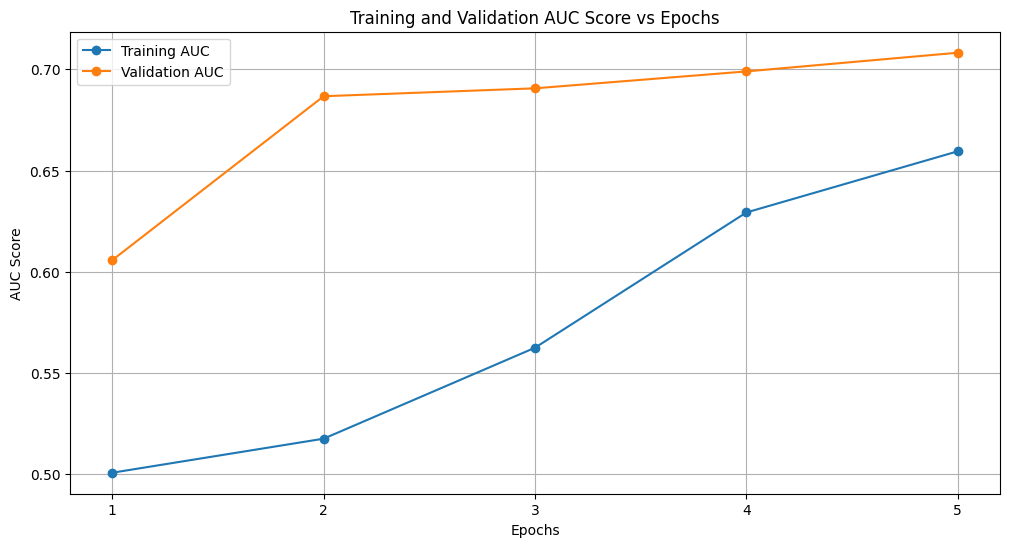

128/128 [==============================] - 129s 1s/step - loss: 0.6540 - auc: 0.6595 - val_loss: 0.6286 - val_auc: 0.7082
Epoch 6/20
 16/128 [==>...........................] - ETA: 1:33 - loss: 0.6703 - auc: 0.6322

KeyboardInterrupt: 

In [56]:
with tf.device('/GPU:0'):
    # Create the model
    model = create_model(model_in_training, 
                        num_conv_layers=3,
                        dropout_rate = 0.2,
                        num_filters = 64,
                        use_custom_layers=True)

    # Instantiate the custom callback
    plot_callback = PlotAUC()

    # Train the model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs=20,
                        batch_size=batch_size,
                        steps_per_epoch = (len(X_train)//batch_size), 
                        callbacks=[plot_callback])

### Evaluation

In [59]:
test_loss, test_auc = model.evaluate(X_test, y_test, verbose=1)

print("Test Loss:", test_loss)
print("Test AUC:", test_auc)

33/33 [==============================] - 20s 583ms/step - loss: 0.5471 - auc: 0.7977
Test Loss: 0.5471479296684265
Test AUC: 0.7977192401885986


In [63]:
y_pred = model.predict(X_test)
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)
conf_mat = confusion_matrix(y_test, y_pred_binary)

report = classification_report(y_test, y_pred_binary)

print(report)
print("Confusion Matrix:")
print(conf_mat)

33/33 [==============================] - 19s 584ms/step
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       502
           1       0.69      0.88      0.77       523

    accuracy                           0.74      1025
   macro avg       0.76      0.73      0.73      1025
weighted avg       0.75      0.74      0.73      1025

Confusion Matrix:
[[295 207]
 [ 64 459]]


In [ ]:
# # use keras wrapper
# model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16)

# # hyperparameters to be searched
# param_grid = {
#     'base_model': ['ResNet50', 'VGG16'],
#     'num_conv_layers': [1],
#     'num_filters': [32],
#     'filter_size': [(3, 3)],
#     'dropout_rate': list(np.arange(0, 0.2, 0.1))  
# }

# # gridsearch
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# grid.fit(X_train, y_train_binary)

# # Evaluate performance
# print("Best hyperparameters found: ", grid.best_params_)
# best_model = grid.best_estimator_.model

C:\Users\zhenq\AppData\Local\Temp\ipykernel_20280\1673432784.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16)


Epoch 1/10
205/205 [==============================] - 75s 346ms/step - loss: 1.0433 - accuracy: 0.5015
Epoch 2/10
 79/205 [==========>...................] - ETA: 43s - loss: 1.0227 - accuracy: 0.4834

KeyboardInterrupt: 

### Evaluate the model performance

In [ ]:
# def evaluate_model(runs=5):
#     scores = [] 
#     for i in range(runs):
#         print('Executing run %d' % (i+1))
#         model = create_model() # input the best parameters found in the previous gridsearch
#         model.fit(X_test,
#                   callbacks=[],
#                   epochs=epochs, verbose=0)
#         print(' * Evaluating model on test set')
#         scores.append(model.evaluate(y_test_encoded, 
#                                      steps = y_test_encoded.shape[0] // batch_size,
#                                      verbose=0))
#         print(' * Test set Loss: %.4f, Accuracy: %.4f' % (scores[-1][0], scores[-1][1]))
        
#     accuracies = [score[1] for score in scores]     
#     return np.mean(accuracies), np.std(accuracies)
        
# mean_accuracy, std_accuracy = evaluate_model(runs=5)